<a href="https://colab.research.google.com/github/JuliaKoryukova/Machine-Learning/blob/main/%D0%9B%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D1%8B%D0%B5_%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D1%8B_KNN_%D0%9B%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color='1A9BFF' size='6'>Линейные алгоритмы: KNN, Логистическая регрессия</font>  


<font color='1A9BFF'>**Установка и импорт необходимых библиотек**</font>

In [ ]:
# для обработки категориальных переменных
!pip install category_encoders -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 763.1 kB/s eta 0:00:00


In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score, roc_curve
from sklearn.preprocessing import StandardScaler,OneHotEncoder, LabelEncoder


<font color='1A9BFF'>**Загрузка набора данных титаник**</font>

In [ ]:
df = sns.load_dataset('titanic')

## EDA

<font color='1A9BFF'>**Первые 5 строк**</font>

In [ ]:
df.head(5)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [ ]:
df.shape

(891, 15)

<font color='1A9BFF'>**Проверка, все ли типы данных верные.**</font>



In [ ]:
df.dtypes

survived          int64
pclass            int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
embarked         object
class          category
who              object
adult_male         bool
deck           category
embark_town      object
alive            object
alone              bool
dtype: object

<font color='1A9BFF'>**Проверка на пропуски**</font>



In [ ]:
df.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64


Признаки age, embarked, embark_town нужно преобразовать, признак deck удалить, так как слишком много пропущенных значений

<font color='1A9BFF'>**анализ категориальных переменных**</font>



сколько категориальных признаков

In [ ]:
category_cols = [col for col, dtype in df.dtypes.items() if dtype.name == 'category' or dtype.name == 'object']
category_cols

['sex', 'embarked', 'class', 'who', 'deck', 'embark_town', 'alive']

Значения категориальных признаков

In [ ]:
df.sex.value_counts()

sex
male      577
female    314
Name: count, dtype: int64

In [ ]:
df.embarked.value_counts()

embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [ ]:
df['class'].value_counts()

class
Third     491
First     216
Second    184
Name: count, dtype: int64

In [ ]:
df.who.value_counts()

who
man      537
woman    271
child     83
Name: count, dtype: int64

In [ ]:
df.deck.value_counts()

deck
C    59
B    47
D    33
E    32
A    15
F    13
G     4
Name: count, dtype: int64

In [ ]:
df.embark_town.value_counts()

embark_town
Southampton    644
Cherbourg      168
Queenstown      77
Name: count, dtype: int64

In [ ]:
df.alive.value_counts()

alive
no     549
yes    342
Name: count, dtype: int64


В модели буду использовать все категориальные признаки, кроме deck - очень много пропущенных значений


In [ ]:
df.drop(columns=['deck'], inplace=True)

In [ ]:
df.shape

(891, 14)

## Разделим выборку на тренировочную и тестовую

In [ ]:
x = df.drop(columns=['survived'])
y = df['survived']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
x_train.shape, x_test.shape

((712, 13), (179, 13))

## Подготовка датасета к построению моделей

<font color='1A9BFF'>**Обработка пропусков**</font>



In [ ]:
# для признака 'age'
x_train.age.fillna(x_train.age.median(numeric_only=True), inplace=True)
x_test.age.fillna(x_test.age.median(numeric_only=True), inplace=True)

# для признака 'embarked'
x_train.embarked.fillna(x_train.embarked.mode()[0], inplace=True)
x_test.embarked.fillna(x_test.embarked.mode()[0], inplace=True)

# для признака 'embark_town'
x_train.embark_town.fillna(x_train.embark_town.mode()[0], inplace=True)
x_test.embark_town.fillna(x_test.embark_town.mode()[0], inplace=True)

In [ ]:
x_train.isna().sum(), x_test.isna().sum()

(pclass         0
 sex            0
 age            0
 sibsp          0
 parch          0
 fare           0
 embarked       0
 class          0
 who            0
 adult_male     0
 embark_town    0
 alive          0
 alone          0
 dtype: int64,
 pclass         0
 sex            0
 age            0
 sibsp          0
 parch          0
 fare           0
 embarked       0
 class          0
 who            0
 adult_male     0
 embark_town    0
 alive          0
 alone          0
 dtype: int64)

<font color='1A9BFF'>**Обработка категориальных признаков**</font>



In [ ]:
# Сброс индексов
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
# Разделение на числовые и категориальные признаки
feat_number = x_train.select_dtypes(include='number').columns
feat_cat = x_train.select_dtypes(exclude='number').columns

In [ ]:
# Mean target encoding для категориальных признаков
target_enc = ce.TargetEncoder(cols=feat_cat)
x_train[feat_cat] = target_enc.fit_transform(x_train[feat_cat], y_train)
x_test[feat_cat] = target_enc.transform(x_test[feat_cat])

In [ ]:
# Стандартизация признаков
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
x_train_scaled_df = pd.DataFrame(x_train_scaled)
x_train_scaled_df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-1.614136,-0.72431,1.253641,-0.470722,-0.479342,-0.078684,-0.497248,1.464841,-0.790136,-0.805076,-0.497248,-0.776919,-0.812203
1,-0.400551,-0.72431,-0.477284,-0.470722,-0.479342,-0.377145,-0.497248,0.678892,-0.790136,-0.805076,-0.497248,-0.776919,-0.812203
2,0.813034,-0.72431,0.215086,-0.470722,-0.479342,-0.474867,-0.497248,-0.857492,-0.790136,-0.805076,-0.497248,-0.776919,-0.812203


## Построение модели knn

<font color='1A9BFF'>**1. Задаю сетку параметров для параметров: n_neighbors, p**</font>   
<font color='1A9BFF'>**2. С помощью gridsearch выбираю наилучшие параметры n_neighbors, p**</font>   
<font color='1A9BFF'>**3. С помощью кросс-валидации хочу убедиться, что модель с минимальным переобучением**</font>



In [ ]:
param_grid = {'n_neighbors': range(1, 21, 5), 'p':[1, 2]}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 21, 5), 'p': [1, 2]},
             scoring='accuracy')

In [ ]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008445,0.009348,0.030030,0.009827,1,1,"{'n_neighbors': 1, 'p': 1}",0.979021,0.979021,0.978873,1.000000,0.985915,0.984566,0.008172,2
1,0.003632,0.001781,0.031996,0.005852,1,2,"{'n_neighbors': 1, 'p': 2}",0.993007,0.986014,0.985915,1.000000,1.000000,0.992987,0.006277,1
2,0.004052,0.002697,0.026162,0.006276,6,1,"{'n_neighbors': 6, 'p': 1}",0.986014,0.958042,0.964789,0.936620,0.964789,0.962051,0.015824,5
3,0.004673,0.003011,0.022295,0.006438,6,2,"{'n_neighbors': 6, 'p': 2}",1.000000,0.965035,0.978873,0.957746,0.985915,0.977514,0.014997,3
4,0.003346,0.001817,0.022838,0.008877,11,1,"{'n_neighbors': 11, 'p': 1}",0.972028,0.965035,0.964789,0.936620,0.957746,0.959244,0.012180,6
5,0.003822,0.002081,0.024522,0.003492,11,2,"{'n_neighbors': 11, 'p': 2}",0.972028,0.965035,0.978873,0.929577,0.964789,0.962060,0.017050,4
6,0.003247,0.001031,0.035361,0.004462,16,1,"{'n_neighbors': 16, 'p': 1}",0.937063,0.958042,0.943662,0.950704,0.950704,0.948035,0.007126,8
7,0.004293,0.001041,0.029931,0.008978,16,2,"{'n_neighbors': 16, 'p': 2}",0.951049,0.951049,0.964789,0.936620,0.950704,0.950842,0.008909,7


In [ ]:
grid_search.best_params_

{'n_neighbors': 1, 'p': 2}

In [ ]:
best_knn = grid_search.best_estimator_
best_params = grid_search.best_params_
print(best_knn)
print(best_params)

KNeighborsClassifier(n_neighbors=1)
{'n_neighbors': 1, 'p': 2}


In [ ]:
cv_scores = cross_val_score(best_knn, x_train_scaled, y_train, cv=5, scoring='accuracy')
print(cv_scores)
print(cv_scores.mean(axis=0))

[0.99300699 0.98601399 0.98591549 1.         1.        ]
0.9929872943957452


In [ ]:
# Предсказания knn
y_train_pred_knn = best_knn.predict(x_train_scaled)
y_test_pred_knn = best_knn.predict(x_test_scaled)
y_train_proba_knn = best_knn.predict_proba(x_train_scaled)[:, 1]
y_test_proba_knn = best_knn.predict_proba(x_test_scaled)[:, 1]

# Матрица ошибок
error_matr_train_knn = confusion_matrix(y_train, y_train_pred_knn)
error_matr_test_knn = confusion_matrix(y_test, y_test_pred_knn)
print('Матрица ошибок train:', error_matr_train_knn)
print('Матрица ошибок test:', error_matr_test_knn)

# Метрики для KNN
# accuracy
accuracy_train_knn = accuracy_score(y_train, y_train_pred_knn)
accuracy_test_knn = accuracy_score(y_test, y_test_pred_knn)
print('Accuracy train:', accuracy_train_knn)
print('Accuracy test:', accuracy_test_knn)

# precision
precision_train_knn = precision_score(y_train, y_train_pred_knn)
precision_test_knn = precision_score(y_test, y_test_pred_knn)
print('Training Precision:', precision_train_knn)
print('Test Precision:', precision_test_knn)

# recall
recall_train_knn = recall_score(y_train, y_train_pred_knn)
recall_test_knn = recall_score(y_test, y_test_pred_knn)
print('Training Recall:', recall_train_knn)
print('Test Recall:', recall_test_knn)

# AUC ROC
auc_roc_train_knn = roc_auc_score(y_train, y_train_proba_knn)
auc_roc_test_knn = roc_auc_score(y_test, y_test_proba_knn)
print('AUC ROC train:', auc_roc_train_knn)
print('AUC ROC test:', auc_roc_test_knn)

Матрица ошибок train: [[444   0]
 [  0 268]]
Матрица ошибок test: [[104   1]
 [  1  73]]
Accuracy train: 1.0
Accuracy test: 0.9888268156424581
Training Precision: 1.0
Test Precision: 0.9864864864864865
Training Recall: 1.0
Test Recall: 0.9864864864864865
AUC ROC train: 1.0
AUC ROC test: 0.9884813384813385


## Построение модели логистическая регрессия

<font color='1A9BFF'>**1. Задаю сетку параметров для параметров: тип регуляризации, параметр регуляризации**</font>   
<font color='1A9BFF'>**2. С помощью gridsearch выбираю наилучшие параметров**</font>   
<font color='1A9BFF'>**3. С помощью кросс-валидации хочу убедиться, что модель с минимальным переобучением**</font>



In [ ]:
# Сетка параметров
param_grid_logr = {'C': [0.01, 0.1, 1, 10, 20, 30, 50, 100], 'penalty': ['l1', 'l2']}

# Модель логистической регрессии
logreg_model = LogisticRegression(solver='saga', max_iter=100000)

# Объект RandomizedSearchCV с моделью логистической регрессии и сеткой параметров
random_grid_search_logr = RandomizedSearchCV(logreg_model, param_distributions = param_grid_logr, n_iter=10, cv=5, scoring='accuracy')
random_grid_search_logr.fit(x_train_scaled, y_train)

print('Лучшие значения параметров:', random_grid_search_logr.best_params_)
best_logr_params = random_grid_search_logr.best_params_
best_logr_model = LogisticRegression(solver='saga', max_iter=100000, **best_logr_params)

cv_scores = cross_val_score(best_logr_model, x_train_scaled, y_train, cv=5, scoring='accuracy')
print(cv_scores)
print(cv_scores.mean(axis=0))

Лучшие значения параметров: {'penalty': 'l1', 'C': 50}
[1. 1. 1. 1. 1.]
1.0


In [ ]:
# Построение модели логистической регрессии
best_logreg_model = LogisticRegression(solver='saga',  max_iter=1000, **random_grid_search_logr.best_params_)
best_logreg_model.fit(x_train_scaled, y_train)

LogisticRegression(C=50, max_iter=1000, penalty='l1', solver='saga')

## Оценка качества  моделей и выбор наилучшей



<font color='1A9BFF'>**Считаю метрики качества: матрицу ошибок, accuracy, precision, recall, AUC ROC**</font>   

In [ ]:
# best threshold
def calc_optimal_cutoff(y_pred, y_fact):
  # Оптимальный порог
  f1_list = []
  thresholds = np.linspace(0, 1, num=100)
  for threshold in thresholds:
    y_pred_thresholded = (y_pred >= threshold).astype(int)

    f1 = f1_score(y_fact, y_pred_thresholded)
    f1_list.append(f1)

  # Индекс максимальной f1
  best_f1_index = np.argmax(f1_list)
  best_threshold = thresholds[best_f1_index]
  print('Оптимальный порог:', best_threshold)
  print('максимальная F1-мера:', f1_list[best_f1_index])

  return best_threshold

In [ ]:
# Предсказания
y_train_proba_logr = best_logreg_model.predict_proba(x_train_scaled)[:, 1]
y_test_proba_logr = best_logreg_model.predict_proba(x_test_scaled)[:, 1]

best_threshold = calc_optimal_cutoff(y_train_proba_logr, y_train)

y_train_pred_logr = (y_train_proba_logr >= best_threshold).astype(int)
y_test_pred_logr = (y_test_proba_logr >= best_threshold).astype(int)


# Матрица ошибок
error_matr_train_logr = confusion_matrix(y_train, y_train_pred_logr)
error_matr_test_logr = confusion_matrix(y_test, y_test_pred_logr)
print('Матрица ошибок train:', error_matr_train_logr)
print('Матрица ошибок test:', error_matr_test_logr)

# accuracy
accuracy_train_logr = accuracy_score(y_train, y_train_pred_logr)
accuracy_test_logr = accuracy_score(y_test, y_test_pred_logr)
print('Accuracy train:', accuracy_train_logr)
print('Accuracy test:', accuracy_test_logr)

# precision
precision_train_logr = precision_score(y_train, y_train_pred_logr)
precision_test_logr = precision_score(y_test, y_test_pred_logr)
print('Training Precision:', precision_train_logr)
print('Test Precision:', precision_test_logr)

# recall
recall_train_logr =  recall_score(y_train, y_train_pred_logr)
recall_test_logr =  recall_score(y_test, y_test_pred_logr)
print('Training Recall:', recall_train_logr)
print('Test Recall:', recall_test_logr)

# AUC ROC
auc_roc_train_logr = roc_auc_score(y_train, y_train_proba_logr)
auc_roc_test_logr = roc_auc_score(y_test, y_test_proba_logr)
print('AUC ROC train:', auc_roc_train_logr)
print('AUC ROC test:', auc_roc_test_logr)

Оптимальный порог: 0.010101010101010102
максимальная F1-мера: 1.0
Матрица ошибок train: [[444   0]
 [  0 268]]
Матрица ошибок test: [[105   0]
 [  0  74]]
Accuracy train: 1.0
Accuracy test: 1.0
Training Precision: 1.0
Test Precision: 1.0
Training Recall: 1.0
Test Recall: 1.0
AUC ROC train: 1.0
AUC ROC test: 1.0



<font color='1A9BFF'>**Строю график ROC кривой**</font>   

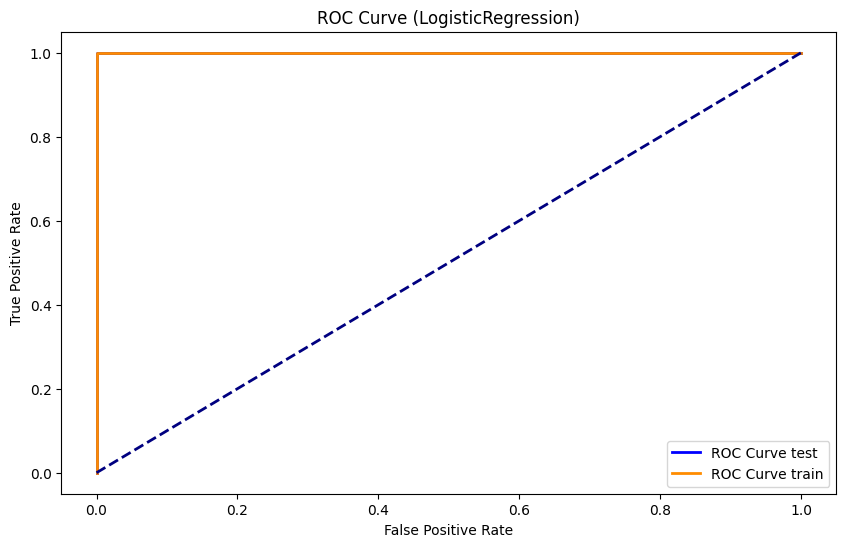

In [ ]:
# Коэффициенты
fpr_test, tpr_test, best_threshold = roc_curve(y_test, y_test_proba_logr)
fpr_train, tpr_train, best_threshold = roc_curve(y_train, y_train_proba_logr)

plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label = 'ROC Curve test')
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label = 'ROC Curve train')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title(f'ROC Curve ({type(best_logreg_model).__name__})')
plt.show()

<font color='1A9BFF'>**Сравниваю модель knn и модель логистическая регрессия, выбираю наилучшую**</font>   



In [ ]:
# Создание таблицы с метриками
metrics_data = {
    'params': ['knn', 'logreg'],
    'Test_Precision': [precision_test_knn, precision_test_logr],
    'Training_Precision': [precision_train_knn, precision_train_logr],
    'Test_Recall': [recall_test_knn, recall_test_logr],
    'Training_Recall': [recall_train_knn, recall_train_logr],
    'roc_auc_train': [auc_roc_train_knn, auc_roc_train_logr],
    'roc_auc_test': [auc_roc_test_knn, auc_roc_test_logr],
    'dif_Precision': [precision_train_knn - precision_test_knn, precision_train_logr - precision_test_logr],
    'dif_roc_auc': [auc_roc_train_knn - auc_roc_test_knn, auc_roc_train_logr - auc_roc_test_logr],
    'dif_Recall': [recall_train_knn - recall_test_knn, recall_train_logr - recall_test_logr]
}
metrics_df = pd.DataFrame(metrics_data)
print(metrics_df)

   params  Test_Precision  Training_Precision  Test_Recall  Training_Recall  \
0     knn        0.986486                 1.0     0.986486              1.0   
1  logreg        1.000000                 1.0     1.000000              1.0   

   roc_auc_train  roc_auc_test  dif_Precision  dif_roc_auc  dif_Recall  
0            1.0      0.988481       0.013514     0.011519    0.013514  
1            1.0      1.000000       0.000000     0.000000    0.000000  


In [ ]:
metrics_df.T

,0,1
params,knn,logreg
Test_Precision,0.986486,1.0
Training_Precision,1.0,1.0
Test_Recall,0.986486,1.0
Training_Recall,1.0,1.0
roc_auc_train,1.0,1.0
roc_auc_test,0.988481,1.0
dif_Precision,0.013514,0.0
dif_roc_auc,0.011519,0.0
dif_Recall,0.013514,0.0



Обе модели показывают высокие значения точности и полноты как на тренировочных, так и на тестовых данных.
Значения метрик почти идентичны, значит, модели не переобучены.
Значения AUC ROC высоки, значит, модели хорошо различают классы.
KNN показывает высокие результаты, логистическая регрессия показывает идеальные значения метрик, поэтому имеет незначительное преимущество.